In [ ]:
! pip install torch-summary
! pip install torchaudio

     |████████████████████████████████| 1.9MB 15.8MB/s 


In [ ]:
# Either of these lines should work but I was having issues with the second one
!curl https://colab.chainer.org/install | sh -
#!pip install curl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7117      0 --:--:-- --:--:-- --:--:--  7085
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.7MB 52kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
from torchsummary import summary
import time
from sklearn.preprocessing import LabelEncoder
import librosa.display
import math
import os
from textwrap import dedent
import torchaudio

IRMAS_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/IRMAS-TrainingData/"
JSON_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/json_files/"
filename = "irmas_data_mfcc13_hop_length256_n_fft2048.json"

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
paths = []
# https://stackoverflow.com/a/16465439
for root, dirs, files in os.walk(IRMAS_PATH):
  for file in files:    
    if file.endswith('.wav'):
      paths.append(os.path.join(root, file))

paths = np.array(paths)
signal, sr = librosa.load(paths[0], sr=44100)

In [ ]:
stft = librosa.core.stft(signal, hop_length=512, n_fft=2048)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)[np.newaxis,...]
    

In [ ]:
stft = librosa.core.stft(signal, hop_length=512, n_fft=2048)
stft

array([[ 4.3201212e-02+0.00000000e+00j, -1.2204819e-01+0.00000000e+00j,
        -2.1960783e-01+0.00000000e+00j, ...,
         4.9458912e-01+0.00000000e+00j,  2.2456717e-01+0.00000000e+00j,
        -4.6706793e-01+0.00000000e+00j],
       [-2.3611242e-01-4.52654407e-17j,  1.9204909e-01-1.66696712e-01j,
         9.8022006e-02+6.59863278e-02j, ...,
        -3.9409488e-01+5.91777042e-02j, -2.5006872e-01-3.13486278e-01j,
         4.5732495e-01-3.77035528e-01j],
       [ 4.7932851e-01-1.69703964e-16j, -2.5949171e-01-5.43447360e-02j,
        -1.7795241e-02-4.19838866e-03j, ...,
         1.5095879e-01+1.81638226e-02j,  5.6959353e-02-1.75287481e-02j,
        -2.3463100e-01+4.53515738e-01j],
       ...,
       [-1.2286117e-03-2.03366531e-18j,  6.2146538e-04-7.28026789e-05j,
         4.1129580e-05+1.13404829e-04j, ...,
         5.4625161e-07+1.42484176e-04j, -6.3937085e-05-2.82542111e-04j,
         2.1983410e-04+5.79778163e-04j],
       [ 1.1814685e-03-8.86335276e-17j,  2.3100461e-05-5.53161837e-0

In [ ]:
signal_tensor = torch.from_numpy(signal)
stft_torch = torch.stft(signal_tensor, hop_length=512, n_fft=2048, return_complex=True)
stft_torch.shape
spectrogram = torch.abs(stft_torch)
spectrogram.shape

torch.Size([1025, 259])

In [ ]:
spectrogram_transformer = torchaudio.transforms.Spectrogram(
    n_fft=2048, hop_length=512
)
amp_to_db = torchaudio.transforms.AmplitudeToDB()

In [ ]:
signal_tensor = torch.from_numpy(signal)
spectrogram = spectrogram_transformer.forward(signal_tensor)
spectrogram = amp_to_db.forward(spectrogram)
spectrogram.shape

torch.Size([1025, 259])

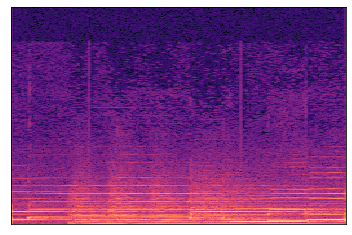

In [ ]:
spectrogram_numpy = spectrogram.numpy()
librosa.display.specshow(spectrogram_numpy, sr=44100, hop_length=512)

In [ ]:
class IRMASDataset_fft(Dataset):
  def __init__(self, IRMAS_PATH, hop_length=512, n_fft=2048, transform=None,
               device='cpu'):
    
    # get filepaths
    self.paths = []
    # https://stackoverflow.com/a/16465439
    for root, dirs, files in os.walk(IRMAS_PATH):
      for file in files:    
        if file.endswith('.wav'):
          self.paths.append(os.path.join(root, file))

    # encode targets
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

    # fft params
    self.hop_length = hop_length
    self.n_fft = n_fft

    # transforms
    self.transform = transform

    # device
    self.device = device

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())
    
    # load the audio file
    signal, sr = librosa.load(self.paths[idx], sr=44100)

    # apply tranforms
    if self.transform:
      signal = self.transform(sample)
    # labels
    primary_instrument = self.encoder.transform(
      [np.array(self.paths[idx].split("/")[-2])]
    )

    sample = {'data': signal, 'instrument': primary_instrument}
    return sample

# Prepare Dataset

In [ ]:
def prep_dataset(val_split=0.2, batch_size=1,
                 hop_length=512, n_fft=2048, transform=None):

  dataset = IRMASDataset_fft(IRMAS_PATH=IRMAS_PATH, hop_length=hop_length,
                             n_fft=n_fft, transform=transform)
  train_set, val_set = random_split(dataset, [round(len(dataset) * (1-val_split)), round(len(dataset)*val_split)])

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader, dataset

# Training Pipeline

In [ ]:
def train_model(model_id="TestModel",
                num_epochs=2, interval=16, lr=0.001, batch_size=64,
                val_split=0.2, save_checkpoint=False, checkpoint_path="",
                notes="", checkpoint_name="utitled.pt", criterion=torch.nn.NLLLoss(),
                patience=None, min_epochs=5, buffer=0.05, dropout_prob=None,
                model_args={}, experiment_params={}, hop_length=512, n_fft=2048,
                transform=None):
  """Model training loop for music analysis project. Currently, this loop only supports
  models that take input in the shape [mini_batch, channels, L, W].

  :param filename:
  :param model_id:
  :param num_epochs:
  :param interval:
  :param lr:
  :param batch_size:
  :param val_split:
  :param save_checkpoint:
  :param checkpoint_path:
  :param notes:
  :param checkpoint name:
  :param criterion:
  :param patience: If validation loss does not improve over this many epochs, stop training
  """

  # Initialize device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("device: ", device)
  
  # get train and validation set, print metadata
  train_loader, val_loader, dataset = prep_dataset(
      batch_size=batch_size, val_split=val_split,
      hop_length=hop_length, n_fft=n_fft, transform=transform)

  # get number of train and validdation samples
  train_samples = round(len(dataset) * (1-val_split))
  val_samples = round(len(dataset) * val_split)

  # initialize loss history and accuracy history for each epoch
  # this is the stored history for the train and validation metrics
  epoch_hist = []
  avg_train_loss_hist = []  # training loss for each epoch
  std_train_loss_hist = []
  avg_val_loss_hist = []    # validation loss for each epoch
  std_val_loss_hist = []
  train_acc_hist = []       # training accuracy for each epoch
  val_acc_hist = []         # validation accuracy for each epoch

  # get one sample to load initial shape for neural net
  single_sample = dataset[0]
  data = np.array(single_sample['data'])
  print("train model: data loaders initialized")
  print("sample shape = ", one_fft.shape)

  # initialize model
  #model = models_dict[model_id](one_mfcc, dropout_prob).to(device)
  model = models_dict[model_id](one_fft, **model_args).to(device)
  print("model loaded")
  summary_str = str(summary(model, one_fft.shape, verbose=0))

  print(summary_str)

  # initialize optimizer and criterion
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  print("criterion: ", criterion)

  n_train_steps = len(train_loader)
  n_val_steps = len(val_loader)

  ### loop epochs
  for epoch in range(num_epochs):
    print("\n\ntraining epoch: ", epoch)
    epoch_hist.append(epoch+1)
    epoch_time_start = time.time()
    interval_time_start = time.time()
    model.to(device)

    # at the start of the epoch, set all tracked params to zero
    train_losses = []
    val_losses = []
    inter_epoch_loss = []
    train_num_correct = 0
    val_num_correct = 0

    # set params to be tracked within the epoch ("inter-epoch")
    # these will be outputted at each interval, but not saved
    inter_epoch_num_correct = 0

    ### Training loop
    model.train()
    print("model set to train")
    for i, sample in enumerate(train_loader):

      # prep input and target tensor
      input_tensor = torch.from_numpy(
          np.array(sample['fft']).astype(np.float32)).to(device)
      target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

      # make predictions
      predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

      # compute loss and do back-propagation
      loss = criterion(predictions, target_tensor)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # append the loss to overall 
      train_losses.append(loss.item())
      inter_epoch_loss.append(loss.item())

      # compute accuracies
      with torch.no_grad():

        # inter-epoch accuracy (reset this at each interval)
        inter_epoch_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        
        # epoch accuracy (this is tracked and saved)
        train_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])

      # print step info
      if i % interval == 0:

        # time elapsed
        interval_time_end = time.time()

        # compute mean and std of losses
        inter_epoch_loss_avg = np.mean(inter_epoch_loss)
        inter_epoch_loss_std = np.std(inter_epoch_loss)
        
        # compute inter-epoch accuracy
        # note, this accuracy may be incorrect at the end of each epoch
        # when the batch size is slightly different
        acc = inter_epoch_num_correct / (interval*batch_size)
        print(f"Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{n_train_steps}], ",
              f"Loss: {inter_epoch_loss_avg:.4f} +/- {inter_epoch_loss_std:.4f}, ",
              f"accuracy: {acc}, "
              f"time elapsed = {interval_time_end-interval_time_start}s")
        interval_time_start = time.time()

        # reset inter_epoch metrics
        inter_epoch_num_correct = 0
        inter_epoch_loss = []

    ### training loop finished
    # append the accuracy
    train_acc_hist.append(train_num_correct / train_samples)

    ### Validation loop
    model.eval()
    print("model set to eval")
    with torch.no_grad():

      num_correct = 0
      for i, sample in enumerate(val_loader):
        
        # prep input and target tensor
        input_tensor = torch.from_numpy(
            np.array(sample['fft']).astype(np.float32)).to(device)
        target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

        # make predictions
        predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

        # compute and append losses
        loss = criterion(predictions, target_tensor)
        val_losses.append(loss.item())

        # get num correct to comput accuracy
        with torch.no_grad():
          val_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
            for i in range(len(target_tensor))])
      
      ### validation loop finished. prep model and metrics for saving
      # calculate validation accuracy
      val_acc_hist.append(val_num_correct / val_samples)

      # calculate mean and standard deviation of losses
      avg_train_loss = np.mean(train_losses)
      std_train_loss = np.std(train_losses)
      avg_val_loss = np.mean(val_losses)
      std_val_loss = np.std(val_losses)

      # append mean and standard deviation to histories
      avg_train_loss_hist.append(avg_train_loss) 
      std_train_loss_hist.append(std_train_loss)  
      avg_val_loss_hist.append(avg_val_loss)
      std_val_loss_hist.append(std_val_loss)
    
    ### epoch training finished, output results and save checkpoint

    # text output
    epoch_time_end = time.time()
    print(f"\nEPOCH FINISHED: , ",
          f"training acc = {train_acc_hist[-1]}, ",
          f"val acc = {val_acc_hist[-1]}, ",
          f"time elapsed = {epoch_time_end-epoch_time_start}s")
    
    # make a plot
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    #ax.scatter(epoch_hist, avg_train_loss_hist, c='r', label="train loss", )
    ax[0].plot(epoch_hist, avg_train_loss_hist, 'ro--', label="train loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_train_loss_hist, yerr=std_train_loss_hist,
                capsize=5, ls='none', color='r')

    # ax.scatter(epoch_hist, avg_val_loss_hist, c='b', label="val loss", )
    ax[0].plot(epoch_hist, avg_val_loss_hist, 'ko--', label="val loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_val_loss_hist, yerr=std_val_loss_hist,
                capsize=5, ls='none', color='k')
    
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    

    ax[1].plot(epoch_hist, train_acc_hist, 'r-.', label="train accuracy", 
                   marker='s')

    ax[1].plot(epoch_hist, val_acc_hist, 'k-.', label="val accuracy",
                   marker='s')
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylim([0, 1])
    ax[1].legend()
    fig.tight_layout(pad=1)
    plt.show()

    # check validation loss if we need to stop training
    # print("validation loss hist: ", avg_val_loss_hist)
    # if (epoch > patience) and all(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
    #                               for i in range(patience)):
    model.to('cpu')
    if (epoch > min_epochs) and (
        avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + avg_train_loss_hist[-1] + buffer)):
        #avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + buffer)):
                    # and any(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
                    #                                   for i in range(patience)):
      notes = notes + "\n\n stopped early"
      # save model
      # TODO: refactor this so torch.save isn't repeated
      if save_checkpoint:
        torch.save({
            'epochs': epoch_hist,
            'model_id': model_id,
            'model_state_dict': model.state_dict(),
            'avg_train_loss_hist': avg_train_loss_hist,
            'std_train_loss_hist': std_train_loss_hist,
            'avg_val_loss_hist': avg_val_loss_hist,
            'std_val_loss_hist': std_val_loss_hist,
            'train_acc_hist': train_acc_hist,
            'val_acc_hist': val_acc_hist,
            'notes': notes,
            'summary': summary_str,
            'experiment_params': experiment_params,
        }, checkpoint_path+checkpoint_name)
        print("model saved")
        print("stopping early")
        break

    # save model
    if save_checkpoint:
      torch.save({
          'epochs': epoch_hist,
          'model_id': model_id,
          'model_state_dict': model.state_dict(),
          'avg_train_loss_hist': avg_train_loss_hist,
          'std_train_loss_hist': std_train_loss_hist,
          'avg_val_loss_hist': avg_val_loss_hist,
          'std_val_loss_hist': std_val_loss_hist,
          'train_acc_hist': train_acc_hist,
          'val_acc_hist': val_acc_hist,
          'notes': notes,
          'summary': summary_str,
          'experiment_params': experiment_params,
      }, checkpoint_path+checkpoint_name)
      print("model saved")

# Test datset on one datapoint

In [ ]:
train_loader, val_loader, dataset = prep_dataset(
      batch_size=5, val_split=0.2)
single_sample = dataset[0]

one_fft = single_sample['fft']
librosa.display.specshow(one_fft[0,...], sr=44100, hop_length=512)

KeyError: ignored

In [ ]:
single_sample['fft'].shape

(1, 1025, 259)

# Define some model architectures

In [ ]:
class ConvBlock(nn.Module):
  """Convolutional block with conv2d, linear activation, max pooling, and batch norm
  """
  def __init__(self, in_channels, out_channels, conv_kernel_size=3,
               conv_stride=1, conv_padding=0,
               inc_pool=True, pool_kernel_size=2, pool_stride=2):
    super(ConvBlock, self).__init__()
    if inc_pool:
      self.conv_block = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=conv_kernel_size, stride=conv_stride,
                    padding=conv_padding),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride),
          nn.BatchNorm2d(num_features=out_channels)
      ) 
    else:
      self.conv_block = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=conv_kernel_size, stride=conv_stride,
                    padding=conv_padding),
          nn.ReLU(),
          nn.BatchNorm2d(num_features=out_channels)
      ) 

  def forward(self, x):
    x = self.conv_block(x)
    return x

class LinearBlock(nn.Module):
  """Linear block with dense layer, relu, batch norm, then dropout
  """

  def __init__(self, in_features, out_features, dropout_prob=0):
    super(LinearBlock, self).__init__()
    self.linear_block = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=out_features),
        nn.Dropout(p=dropout_prob)
    )

  def forward(self, x):
    x = self.linear_block(x)
    return x

class HeadBlock(nn.Module):
  """Linear block with softmax output"""
  def __init__(self, in_features):
    super(HeadBlock, self).__init__()
    self.head_block = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=11),
        nn.Softmax()
    )

  def forward(self, x):
    x = self.head_block(x)
    return x

class Conv1Layer(nn.Module):

  def __init__(self, single_sample, channels=[8],
               conv_kernel_sizes=[3],
               conv_strides=[1],
               conv_paddings=[0],
               pool_masks=[True],
               pool_kernel_sizes=[2],
               pool_strides=[2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):

    super(Conv1Layer, self).__init__()

    # convolutional blocks
    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
  
    # run a single sample through the convolutional block to get output size
    # https://discuss.pytorch.org/t/convolution-and-pooling-layers-need-a-method-to-calculate-output-size/21895
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
  
    sample_flattened = sample_output1.flatten(start_dim=1)
 
    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))

  def forward(self, x):
    x = self.conv1(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

class Conv3Layer(nn.Module):
  def __init__(self, single_sample, channels=[8, 16, 32],
               conv_kernel_sizes=[3, 3, 3],
               conv_strides=[1, 1, 1],
               conv_paddings=[0, 0, 1,],
               pool_masks=[True, True, True],
               pool_kernel_sizes=[2, 2, 2],
               pool_strides=[2, 2, 2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):
    super(Conv3Layer, self).__init__()

    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
    
    self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
                           conv_kernel_size=conv_kernel_sizes[1],
                           conv_stride=conv_strides[1],
                           conv_padding=conv_paddings[1],
                           inc_pool=pool_masks[1],
                           pool_kernel_size=pool_kernel_sizes[1],
                           pool_stride=pool_strides[1])

    self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
                           conv_kernel_size=conv_kernel_sizes[2],
                           conv_stride=conv_strides[2],
                           conv_padding=conv_paddings[2],
                           inc_pool=pool_masks[2],
                           pool_kernel_size=pool_kernel_sizes[2],
                           pool_stride=pool_strides[2])
    
    # calculate size for linear layers
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
    sample_output2 = self.conv2(sample_output1)
    sample_output3 = self.conv3(sample_output2)
    sample_flattened = sample_output3.flatten(start_dim=1)

    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

class Conv5Layer(nn.Module):
  def __init__(self, single_sample, channels= [8, 8, 32, 32, 64],
               conv_kernel_sizes=[3, 3, 3, 3, 3],
               conv_strides=[1, 1, 1, 1, 1],
               conv_paddings=[0, 0, 1, 1, 1],
               pool_masks=[True, True, True, True, True],
               pool_kernel_sizes=[2, 2, 2, 2, 2],
               pool_strides=[2, 2, 2, 2, 2],
               linear_features=[128, 64],
               dropout_probs=[0, 0]):
    super(Conv5Layer, self).__init__()

    # convolutional layers
    self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
                           conv_kernel_size=conv_kernel_sizes[0],
                           conv_stride=conv_strides[0],
                           conv_padding=conv_paddings[0],
                           inc_pool=pool_masks[0],
                           pool_kernel_size=pool_kernel_sizes[0],
                           pool_stride=pool_strides[0])
    
    self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
                           conv_kernel_size=conv_kernel_sizes[1],
                           conv_stride=conv_strides[1],
                           conv_padding=conv_paddings[1],
                           inc_pool=pool_masks[1],
                           pool_kernel_size=pool_kernel_sizes[1],
                           pool_stride=pool_strides[1])

    self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
                           conv_kernel_size=conv_kernel_sizes[2],
                           conv_stride=conv_strides[2],
                           conv_padding=conv_paddings[2],
                           inc_pool=pool_masks[2],
                           pool_kernel_size=pool_kernel_sizes[2],
                           pool_stride=pool_strides[2])
    
    self.conv4 = ConvBlock(in_channels=channels[2], out_channels=channels[3],
                           conv_kernel_size=conv_kernel_sizes[3],
                           conv_stride=conv_strides[3],
                           conv_padding=conv_paddings[3],
                           inc_pool=pool_masks[3],
                           pool_kernel_size=pool_kernel_sizes[3],
                           pool_stride=pool_strides[3])
    
    self.conv5 = ConvBlock(in_channels=channels[3], out_channels=channels[4],
                           conv_kernel_size=conv_kernel_sizes[4],
                           conv_stride=conv_strides[4],
                           conv_padding=conv_paddings[4],
                           inc_pool=pool_masks[4],
                           pool_kernel_size=pool_kernel_sizes[4],
                           pool_stride=pool_strides[4])
    
    # calculate size for linear layers
    sample_output1 = self.conv1(torch.from_numpy(
        single_sample[np.newaxis,...].astype(np.float32)))
    sample_output2 = self.conv2(sample_output1)
    sample_output3 = self.conv3(sample_output2)
    sample_output4 = self.conv4(sample_output3)
    sample_output5 = self.conv5(sample_output4)
    sample_flattened = sample_output5.flatten(start_dim=1)


    # linear blocks
    self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
                                            out_features=(linear_features[0]),
                                            dropout_prob=dropout_probs[0])
    self.linear2 = LinearBlock(in_features=(linear_features[0]),
                                            out_features=(linear_features[1]),
                                            dropout_prob=dropout_probs[1])
    self.head = HeadBlock(in_features=(linear_features[1]))
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.flatten(start_dim=1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.head(x)
    return x

# Test all architectures

In [ ]:
models_dict = {
    "Conv_1_layer": Conv1Layer,
    "Conv_3_layer": Conv3Layer,
    "Conv_5_layer": Conv5Layer,
}

all_channels = [
  [[8], [16], [32], [64], [128]],

  [[8, 8, 16], [8, 16, 32], [8, 16, 64], [8, 32, 128], [8, 8, 128], [8, 128, 128],
   [32, 32, 64], [32, 64, 128], [32, 128, 128], 
   [64, 64, 128], [128, 128, 128]],
  
  [[8, 8, 8, 8, 8], [8, 8, 16, 16, 32], [8, 8, 16, 32, 64], [8, 8, 32, 64, 128],
   [8, 16, 32, 64, 128], [8, 32, 32, 64, 128],

   [16, 32, 32, 64, 128], [32, 64, 64, 64, 128], [64, 64, 64, 128, 128]]
]

count = 0
model_ids = ["Conv_1_layer", "Conv_3_layer", "Conv_5_layer"]
for i, model_id in enumerate(model_ids):
  print("testing model: ", model_id)

  for channel in all_channels[i]:
    print("*"*80)
    print("*"*80, "\n")
    print("channels: ", channel)

    model = models_dict[model_id](one_fft, channels=channel)
    summary_str = summary(model, one_fft.shape, verbose=0)
    print(summary_str)

    count += 1
print("total models being trained: {}".format(count))

testing model:  Conv_1_layer
********************************************************************************
******************************************************************************** 

channels:  [8]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 511, 128]         --
|    └─Sequential: 2-1                   [-1, 8, 511, 128]         --
|    |    └─Conv2d: 3-1                  [-1, 8, 1023, 257]        80
|    |    └─ReLU: 3-2                    [-1, 8, 1023, 257]        --
|    |    └─MaxPool2d: 3-3               [-1, 8, 511, 128]         --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 511, 128]         16
├─LinearBlock: 1-2                       [-1, 128]                 --
|    └─Sequential: 2-2                   [-1, 128]                 --
|    |    └─Linear: 3-5                  [-1, 128]                 66,977,920
|    |    └─ReLU: 3-6                    [-1, 128]                 --
|    |    └─BatchNorm1d: 3-7             [-1, 128]                 256
|    |    └─Dropout: 3-8                 [-1, 128]                 --
├─LinearBlock: 1-3                       [-1, 64]                  --
|    └

# Run the training pipeline

In [ ]:
### params to vary
all_channels = [
  [[8], [16], [32], [64], [128]],

  [[8, 8, 16], [8, 16, 32], [8, 16, 64], [8, 32, 128], [8, 8, 128], [8, 128, 128],
   [32, 32, 64], [32, 64, 128], [32, 128, 128], 
   [64, 64, 128], [128, 128, 128]],
  
  [[8, 8, 8, 8, 8], [8, 8, 16, 16, 32], [8, 8, 16, 32, 64], [8, 8, 32, 64, 128],
   [8, 16, 32, 64, 128], [8, 32, 32, 64, 128],

   [16, 32, 32, 64, 128], [32, 64, 64, 64, 128], [64, 64, 64, 128, 128]]
]

model_ids = ["Conv_1_layer", "Conv_3_layer", "Conv_5_layer"]

layers = [1, 3, 5]

# define initial args dict
args_dict = {
    'num_epochs': 100,
    'interval': 16,
    'lr': 0.0001,
    'batch_size': 64,
    'val_split': 0.2,
    'save_checkpoint': True,
    'checkpoint_path': '/content/drive/MyDrive/ITCS 5156 project/trained_models/fft CNN tests 4-19/',
    'criterion': torch.nn.CrossEntropyLoss(),
    'patience': 3,
    'min_epochs': 5,
    'buffer': 0.05
}

# including a counter becuase I'm too lazy to figure out how to make one with 
# i and j
for i in range(len(layers)):
  for j, channel in enumerate(all_channels[i]):

    model_temp = models_dict[model_ids[i]](one_fft, channels=channel)
    summary_str = summary(model, one_fft.shape, verbose=0)

    args_dict['model_args'] = {
        'channels': channel
    }
    args_dict['model_id'] = model_ids[i]
    args_dict['checkpoint_name'] = "fft_CNN_{}_layers_channel_{}.pt".format(
        layers[i], j
    )
    
    args_dict['notes'] = dedent("""
      Model trained on 4-19.
      Varying number of convolutional layers and number of channels using FFTs
      instead of MFCCs.
      This network has {} convolutional layers with channels: {}

      Other params: 
      max epochs = 100
      interval (for output) = 16
      lr = 0.0001
      batch_size = 64
      criterion = CrossEntropyLoss
      No dropout layers in linear portion
      buffer (for early stopping) = 0.05

      Model summary: 
      {}
    """.format(layers[i], channel, summary_str))

    args_dict['experiment_params'] = {
        'hop_length': 256,
        'n_fft': 2048,
        'num_conv_layers': layers[i],
        'channels': channel
    }

    # ### output the important stuff before running the model
    # print("=====================================")
    # print(args_dict['model_id'])
    # print(args_dict['checkpoint_name'])
    # print(args_dict['experiment_params'])
    
    # run the pipeline and pray to whatever diety you believe in that I didn't
    # screw this up
    print("running model: id = {}, channels = {}".format(model_ids[i], channel))
    train_model(**args_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


running model: id = Conv_1_layer, channels = [8]
device:  cpu
train model: data loaders initialized
sample shape =  (1, 1025, 259)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 511, 128]         --
|    └─Sequential: 2-1                   [-1, 8, 511, 128]         --
|    |    └─Conv2d: 3-1                  [-1, 8, 1023, 257]        80
|    |    └─ReLU: 3-2                    [-1, 8, 1023, 257]        --
|    |    └─MaxPool2d: 3-3               [-1, 8, 511, 128]         --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 511, 128]         16
├─LinearBlock: 1-2                       [-1, 128]                 --
|    └─Sequential: 2-2                   [-1, 128]                 --
|    |    └─Linear: 3-5                  [-1, 128]                 66,977,920
|    |    └─ReLU: 3-6                    [-1, 128]                 --
|    |    └─BatchNorm1d: 3-7             [-1, 128]                 256
| 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/100], step [1/84],  Loss: 2.4119 +/- 0.0000,  accuracy: 0.001953125, time elapsed = 27.11130976676941s
Epoch [1/100], step [17/84],  Loss: 2.3601 +/- 0.0150,  accuracy: 0.193359375, time elapsed = 276.5228579044342s


KeyboardInterrupt: ignored